In [2]:
from darts.models import Theta, ARIMA, ExponentialSmoothing
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, ModelMode


from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn import set_config
set_config(transform_output = "default")

from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor




from multiprocessing import Pool
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import missingno as msno
from plotly.colors import DEFAULT_PLOTLY_COLORS as colors


from utils import get_idle_proportion, add_time_tag, get_jobs_data
from constant import MAP_TIME_COL, NODE_TO_PARTITION_NAME

# from sklearn import set_config
# set_config(transform_output = "pandas")


# Classic ML and Econometric models training

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('/projects/2/prjs1098/system_analytics_2024/slurm_data')
folder_path_prom_data = Path('/projects/2/prjs1098/system_analytics_2024/prom_data')
folder_path_EAR_data = Path('/projects/2/prjs1098/system_analytics_2024/ear_data')
folder_path_saving_results = Path('./results')


# for getting the up-to-date data run the clenaing_sinfo file
# with the latest data from the system.
file_sinfo = 'sinfo_cleaned_2025-01-22.parquet.gzip'
df = pd.read_parquet(folder_path_slurm_data / file_sinfo)


# this takes a bit of time, so we instead load the result
# df_prom_average = get_prom_average_node_sinfo(all_prom_file_paths[0:2], map_time_col[time_col], time_col)
df_prom_average = pd.read_parquet(folder_path_prom_data /'average_signal_prom'
                                  /'prom_average_data_2025-01-23.parquet.gzip')

# get the latest tables from the EAR data base, this is not up to date. run get_ear_db_data ==> I wish I could change this!
jobs_table_path = folder_path_EAR_data / 'jobs_2025-01-23.parquet.gzip'
apps_table_path = folder_path_EAR_data / 'applications_2025-01-23.parquet.gzip'
df_job_number_history= get_jobs_data(jobs_table_path, apps_table_path)
display(df.sample(n=5), df_prom_average.sample(n=5), df_job_number_history.sample(n=5))




TRAIN_MODE = True
# if TRAIN_MODE is False, ensure that the file exist in the work space
trained_model_parameters = 'all_models_best_params_Jan_23.pickle'

node                time      state
373  tcn1261 2024-12-29 22:00:51       idle
229   tcn456 2024-11-22 10:06:54  allocated
320  tcn1214 2024-12-05 21:50:56       idle
284  tcn1063 2024-11-11 02:57:59       idle
2     tcn114 2024-11-10 13:48:34       idle

node                time  node_arp_entries_min  \
1423623  tcn1192 2024-11-27 22:00:00                   3.0   
3410265   tcn681 2025-01-09 17:00:00                   3.0   
1285419  tcn1149 2024-10-14 10:00:00                   NaN   
2634166   tcn437 2024-10-24 13:00:00                   3.0   
1134780  tcn1100 2024-11-16 00:00:00                   3.0   

         node_arp_entries_max  node_arp_entries_mean  node_arp_entries_median  \
1423623                1514.0                  758.5                    758.5   
3410265                1469.0                  736.0                    736.0   
1285419                   NaN                    NaN                      NaN   
2634166                 901.0                  452.0                    452.0   
1134780                1597.0                  800.0                    800.0   

         node_boot_time_seconds_min  node_boot_time_seconds_max  \
1423623                  1.7289e+09                  1.7289e+09   
3410265                  1.7350e+09                  1.7350e+09   
1285419                         NaN                         NaN   
2634166                  1.7289e+09                  1.7289e+09   
1134780                  1.7289e+09                  1.7289e+09   

         node_boot_time_seconds_mean  node_boot_time_seconds_median  \
1423623                   1.7289e+09                     1.7289e+09   
3410265                   1.7350e+09                     1.7350e+09   
1285419                          NaN                            NaN   
2634166                   1.7289e+09                     1.7289e+09   
1134780                   1.7289e+09                     1.7289e+09   

         node_context_switches_total_min  node_context_switches_total_max  \
1423623                       7.8532e+09                       7.8532e+09   
3410265                       1.6707e+10                       1.6707e+10   
1285419                              NaN                              NaN   
2634166                       1.7395e+09                       1.7395e+09   
1134780                       1.0859e+10                       1.0859e+10   

         node_context_switches_total_mean  node_context_switches_total_median  \
1423623                        7.8532e+09                          7.8532e+09   
3410265                        1.6707e+10                          1.6707e+10   
1285419                               NaN                                 NaN   
2634166                        1.7395e+09                          1.7395e+09   
1134780                        1.0859e+10                          1.0859e+10   

         node_cooling_device_cur_state_min  node_cooling_device_cur_state_max  \
1423623                                0.0                                0.0   
3410265                                0.0                                0.0   
1285419                                NaN                                NaN   
2634166                                0.0                                0.0   
1134780                                0.0                                0.0   

         node_cooling_device_cur_state_mean  \
1423623                                 0.0   
3410265                                 0.0   
1285419                                 NaN   
2634166                                 0.0   
1134780                                 0.0   

         node_cooling_device_cur_state_median  \
1423623                                   0.0   
3410265                                   0.0   
1285419                                   NaN   
2634166                                   0.0   
1134780                                   0.0   

         node_cooling_device_max_state_min  node_cooling_device_max_state_max  \
1423623                                3.0                                3.0   
3410265                                3.0                                3.0   
1285419                                NaN                      

job_id     step_id          start_time            end_time  \
6457377   3732669  4294967291 2023-09-05 06:46:33 2023-09-05 06:49:13   
4067281   2000639        3312 2023-01-03 05:01:26 2023-01-03 05:01:53   
11584197  6433503          25 2024-05-29 17:17:00 2024-05-29 17:18:43   
16207936  8958621        2649 2024-12-09 01:32:47 2024-12-09 01:34:02   
9429712   5426763  4294967291 2024-03-03 11:27:36 2024-03-04 23:27:42   

         start_mpi_time end_mpi_time node_id  signature_id  \
6457377      1970-01-01   1970-01-01  tcn461           NaN   
4067281      1970-01-01   1970-01-01   tcn55           NaN   
11584197     1970-01-01   1970-01-01  tcn214           NaN   
16207936     1970-01-01   1970-01-01  tcn204           NaN   
9429712      1970-01-01   1970-01-01   gcn33           NaN   

          power_signature_id      job_start_time        job_end_time  \
6457377              6575472 2023-09-05 06:46:33 2023-09-05 06:49:13   
4067281              4217165 2022-12-31 07:21:21 2023-01-03 19:56:59   
11584197            11717412 2024-05-29 16:17:00 2024-05-29 22:54:44   
16207936            16472338 2024-12-08 17:07:41 2024-12-09 05:53:15   
9429712              9586178 2024-03-03 11:27:36 2024-03-04 23:27:42   

         job_start_time_date  
6457377           2023-09-05  
4067281           2022-12-31  
11584197          2024-05-29  
16207936          2024-12-08  
9429712           2024-03-03

In [4]:
# remove the latest date from sinfo to align with promehtues
df = add_time_tag(df)
# display a sample
N = len(df)//20
display(df.iloc[N: N + 5, :])

node                time state node_type time_30min_interval  \
5  fcn6 2025-01-13 14:17:35  idle       fcn 2025-01-13 14:00:00   
5  fcn6 2025-01-13 14:18:13  idle       fcn 2025-01-13 14:00:00   
5  fcn6 2025-01-13 14:18:48  idle       fcn 2025-01-13 14:00:00   
5  fcn6 2025-01-13 14:19:35  idle       fcn 2025-01-13 14:00:00   
5  fcn6 2025-01-13 14:21:13  idle       fcn 2025-01-13 14:00:00   

  time_1hour_interval time_2hour_interval time_3hour_interval  \
5 2025-01-13 14:00:00 2025-01-13 14:00:00 2025-01-13 12:00:00   
5 2025-01-13 14:00:00 2025-01-13 14:00:00 2025-01-13 12:00:00   
5 2025-01-13 14:00:00 2025-01-13 14:00:00 2025-01-13 12:00:00   
5 2025-01-13 14:00:00 2025-01-13 14:00:00 2025-01-13 12:00:00   
5 2025-01-13 14:00:00 2025-01-13 14:00:00 2025-01-13 12:00:00   

  time_4hour_interval time_6hour_interval time_12hour_interval  \
5 2025-01-13 12:00:00 2025-01-13 12:00:00  2025-01-13 12:00:00   
5 2025-01-13 12:00:00 2025-01-13 12:00:00  2025-01-13 12:00:00   
5 2025-01-13 12:00:00 2025-01-13 12:00:00  2025-01-13 12:00:00   
5 2025-01-13 12:00:00 2025-01-13 12:00:00  2025-01-13 12:00:00   
5 2025-01-13 12:00:00 2025-01-13 12:00:00  2025-01-13 12:00:00   

  time_day_interval     time_week_interval  
5        2025-01-13  2025-01-13/2025-01-19  
5        2025-01-13  2025-01-13/2025-01-19  
5        2025-01-13  2025-01-13/2025-01-19  
5        2025-01-13  2025-01-13/2025-01-19  
5        2025-01-13  2025-01-13/2025-01-19

In [5]:
"""    
PICK THE TIME INTERVAL THAT WE WANT TO GROUP DATA.
"""

# WHICH TIME INTEVAL MAKES SENSE FOR ML?
time_col = 'time_4hour_interval'

df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# show a smaple
initial_data_size= len(df_stat)
display(df_stat.sample(n=5))
print(f"initial data size: {initial_data_size}")
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

# note the trick here! this happens again in the future for Promethues data
df_last = df.groupby(['node', time_col], as_index=False)[['node', time_col, 'state', 'time']].tail(1).copy()
# merge it with the main
df_stat = pd.merge(df_stat, df_last[['node', time_col, 'state', 'time']],
                   how='left', on=['node', time_col]).copy()
# rename it
df_stat.rename(columns={'time':'time_for_last_state', 'state': 'last_state'}, inplace=True)
# show a sample
display(df_stat.sample(n=10))
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")

df_stat.sort_values(['node', time_col], inplace=True)
# drop some columns
df_stat.drop(['idle_duration', 'all_state_durations_in_interval'],
             axis=1, inplace=True)
display(df_stat.head())

node time_4hour_interval   idle_duration  \
683681   tcn912 2024-12-15 04:00:00 0 days 00:00:00   
163069  tcn1058 2024-11-18 12:00:00 0 days 03:58:23   
121753    gcn82 2024-11-05 12:00:00 0 days 00:00:00   
552236   tcn663 2024-11-20 16:00:00 0 days 00:00:00   
47915     fcn82 2024-11-11 12:00:00 0 days 03:50:00   

       all_state_durations_in_interval  idle_proportion  
683681                 0 days 03:58:42           0.0000  
163069                 0 days 03:58:23           1.0000  
121753                 0 days 03:59:49           0.0000  
552236                 0 days 03:59:21           0.0000  
47915                  0 days 03:51:00           0.9957

initial data size: 728942
Is there duplication in node and time: False


node time_4hour_interval   idle_duration  \
53038     fcn91 2025-01-14 08:00:00 0 days 03:58:12   
294526   tcn170 2024-12-15 00:00:00 0 days 03:58:24   
434864   tcn439 2024-12-20 16:00:00 0 days 02:49:35   
707016   tcn957 2025-01-02 08:00:00 0 days 03:59:27   
173358  tcn1077 2025-01-13 08:00:00 0 days 03:58:40   
94497     gcn28 2024-12-09 00:00:00 0 days 02:37:33   
104015    gcn46 2024-12-15 08:00:00 0 days 00:00:00   
470725   tcn507 2024-11-23 12:00:00 0 days 03:58:23   
713013   tcn969 2024-12-05 20:00:00 0 days 03:58:22   
574220   tcn704 2024-12-20 16:00:00 0 days 03:15:39   

       all_state_durations_in_interval  idle_proportion last_state  \
53038                  0 days 03:58:12           1.0000       idle   
294526                 0 days 03:58:24           1.0000       idle   
434864                 0 days 03:58:10           0.7120       idle   
707016                 0 days 03:59:27           1.0000       idle   
173358                 0 days 03:58:40           1.0000       idle   
94497                  0 days 03:59:25           0.6581      mixed   
104015                 0 days 03:58:05           0.0000   reserved   
470725                 0 days 03:58:23           1.0000       idle   
713013                 0 days 03:58:22           1.0000       idle   
574220                 0 days 03:58:10           0.8215       idle   

       time_for_last_state  
53038  2025-01-14 11:58:32  
294526 2024-12-15 03:59:05  
434864 2024-12-20 19:59:30  
707016 2025-01-02 11:59:27  
173358 2025-01-13 11:59:13  
94497  2024-12-09 03:59:28  
104015 2024-12-15 11:58:58  
470725 2024-11-23 15:59:24  
713013 2024-12-05 23:59:13  
574220 2024-12-20 19:59:30

Is there duplication in node and time: False


node time_4hour_interval  idle_proportion last_state time_for_last_state
0  fcn1 2024-11-04 16:00:00              0.0      mixed 2024-11-04 19:59:37
1  fcn1 2024-11-04 20:00:00              0.0      mixed 2024-11-04 23:59:43
2  fcn1 2024-11-05 00:00:00              0.0      mixed 2024-11-05 03:59:33
3  fcn1 2024-11-05 04:00:00              0.0      mixed 2024-11-05 07:59:32
4  fcn1 2024-11-05 08:00:00              0.0      mixed 2024-11-05 11:59:33

Top 5 nodes with nan values: 
      node
gcn25     35
gcn56     35
tcn542     0
tcn541     0
tcn540     0
dtype: int64


<Axes: >

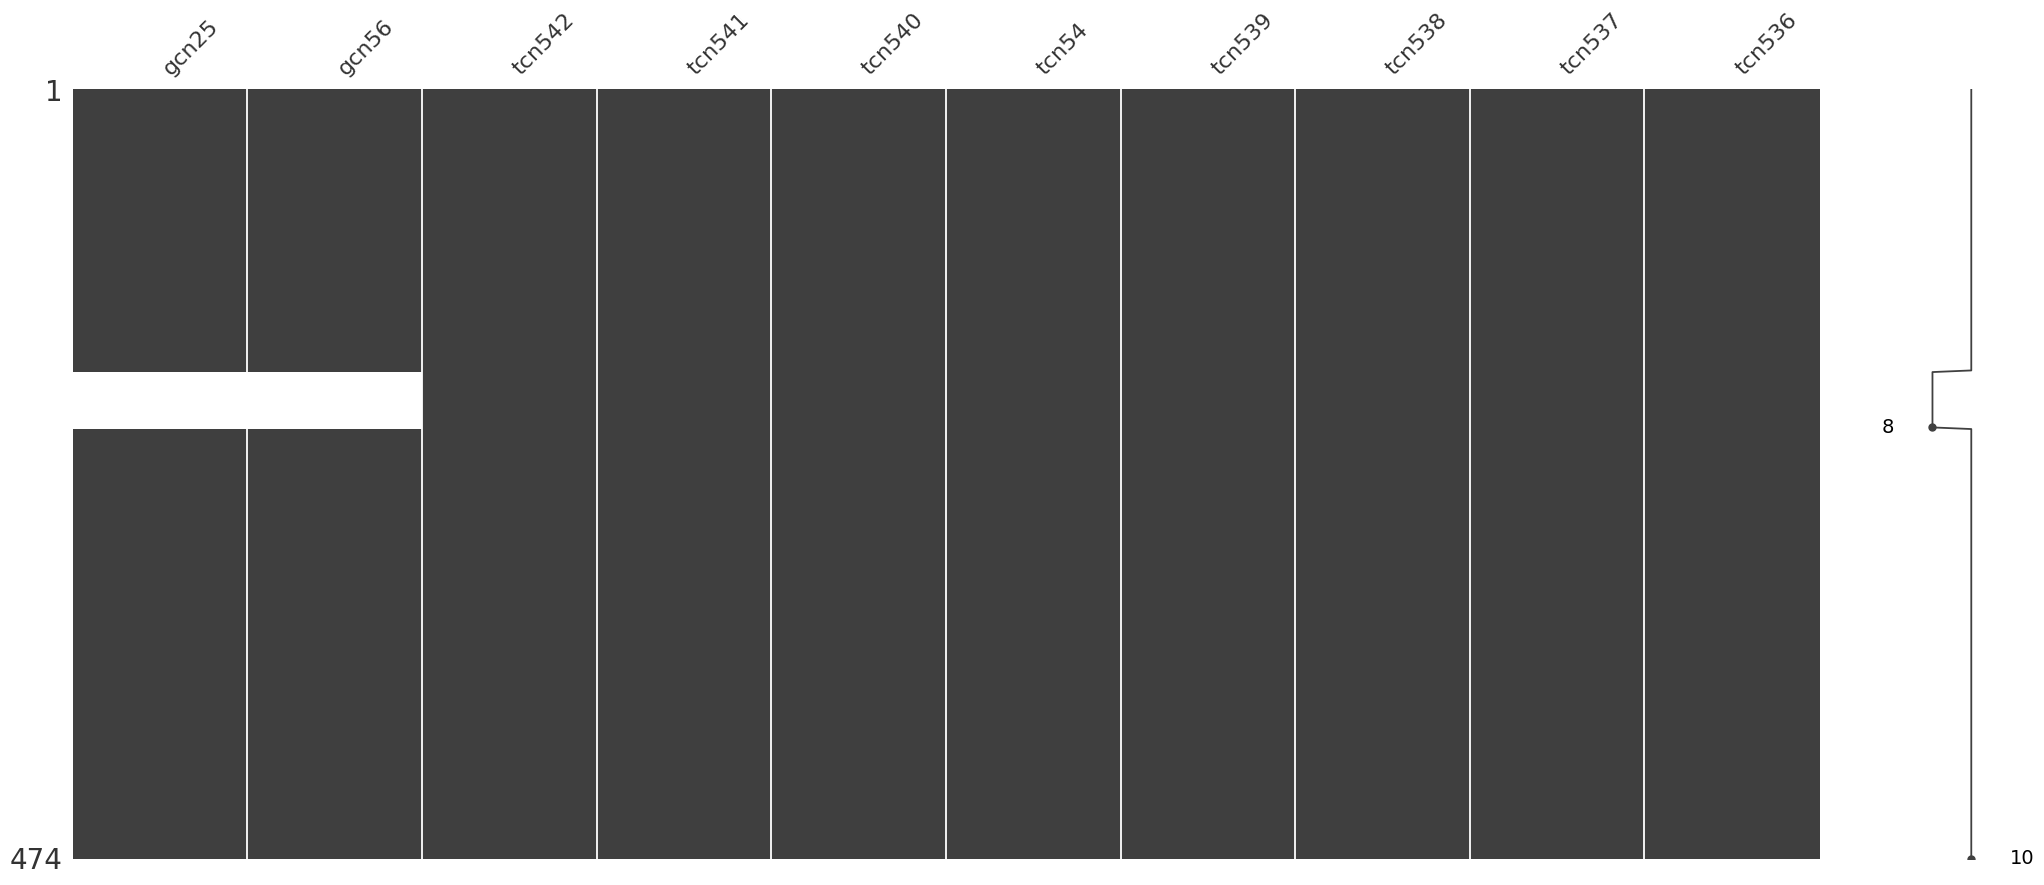

In [6]:
# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(df_stat, index=time_col, columns=['node'], values=['idle_proportion'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
# df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H:%M")
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d")

print(f"""Top 5 nodes with nan values: 
      {df_stat_pivot.isna().sum().sort_values(ascending=False).head()}""")
node_names_with_high_nan_values = df_stat_pivot.isna().sum().sort_values(ascending=False).index.to_list()
df_sorted_nodes = df_stat_pivot[node_names_with_high_nan_values].copy()
msno.matrix(df_sorted_nodes.iloc[:, 0:10])

# we have nan values in the idle proportion!==> it seems that this has happened recently and two of the nodes are not
# showing any state values

In [7]:
"""  
Drop the nodes that have really bad nan values
"""
mask = (df_stat['node'] == 'gcn56') | (df_stat['node'] == 'gcn25')
df_stat = df_stat[~mask].copy()


# Feature engineering


Add new features to the data


In [8]:
# add the lags here; 
time_sample_in_one_day = pd.Timedelta('1day') // MAP_TIME_COL[time_col]

lags = (
    (np.arange(3) + 1).tolist()
    + (np.arange(3) + (time_sample_in_one_day-2)).tolist()
    + (np.arange(3) + (time_sample_in_one_day * 7) - 2).tolist()
)

for i in lags:
    df_stat[f'lag_{i}'] = df_stat.groupby('node', as_index=False)['idle_proportion'].shift(i)
    

# adding aggreation to the signals
rolls = [3 * time_sample_in_one_day, 2 * time_sample_in_one_day,  time_sample_in_one_day]
agg_functions = ['mean', 'std']

for agg_function in agg_functions:
    for roll in rolls:
        df_stat[f'roll_{roll}_{agg_function}'] = (df_stat
                                                  .groupby('node', as_index=False)['idle_proportion']
                                                  .shift(1) # shift to avoid leakage!
                                                  .rolling(roll)
                                                  .agg(agg_function))

# add calender feature like day of the week and month
df_stat['hour_day'] = df_stat[time_col].dt.hour
df_stat['week_day'] = df_stat[time_col].dt.day_of_week
# df_stat['month'] = df_stat[time_col].dt.month


# add parition name, use the map from constant
df_stat['partition'] = (df_stat['node']
                        .apply(lambda x: NODE_TO_PARTITION_NAME
                               .get(x, 'other')))

# add the number that comes after the node as a feature
df_stat['node_number'] = df_stat['node'].str.split('n').str[1].astype(int)


# shifting the last state to avoid data leakage.
df_stat['last_state_lag_1'] = (df_stat
                               .groupby('node', as_index=False)['last_state']
                               .shift(1))
# display some rows   
N = np.random.randint(len(df_stat) - 10)
df_stat.iloc[N:N+10, :]

node time_4hour_interval  idle_proportion last_state  \
550120  tcn659 2025-01-02 00:00:00              1.0       idle   
550121  tcn659 2025-01-02 04:00:00              1.0       idle   
550122  tcn659 2025-01-02 08:00:00              1.0       idle   
550123  tcn659 2025-01-02 12:00:00              1.0       idle   
550124  tcn659 2025-01-02 16:00:00              1.0       idle   
550125  tcn659 2025-01-02 20:00:00              1.0       idle   
550126  tcn659 2025-01-03 00:00:00              1.0       idle   
550127  tcn659 2025-01-03 04:00:00              1.0       idle   
550128  tcn659 2025-01-03 08:00:00              1.0       idle   
550129  tcn659 2025-01-03 12:00:00              1.0       idle   

       time_for_last_state  lag_1  lag_2  lag_3  lag_4   lag_5   lag_6  \
550120 2025-01-02 03:59:54    1.0    1.0    1.0    1.0  0.9526  0.2485   
550121 2025-01-02 07:59:20    1.0    1.0    1.0    1.0  1.0000  0.9526   
550122 2025-01-02 11:59:27    1.0    1.0    1.0    1.0  1.0000  1.0000   
550123 2025-01-02 15:59:48    1.0    1.0    1.0    1.0  1.0000  1.0000   
550124 2025-01-02 19:59:41    1.0    1.0    1.0    1.0  1.0000  1.0000   
550125 2025-01-02 23:59:47    1.0    1.0    1.0    1.0  1.0000  1.0000   
550126 2025-01-03 03:59:53    1.0    1.0    1.0    1.0  1.0000  1.0000   
550127 2025-01-03 07:59:58    1.0    1.0    1.0    1.0  1.0000  1.0000   
550128 2025-01-03 11:59:48    1.0    1.0    1.0    1.0  1.0000  1.0000   
550129 2025-01-03 15:58:10    1.0    1.0    1.0    1.0  1.0000  1.0000   

        lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  \
550120   1.000   1.000   1.000        0.9146        0.8761       0.8669   
550121   1.000   1.000   1.000        0.9174        0.8899       0.9921   
550122   0.644   1.000   1.000        0.9174        0.8899       1.0000   
550123   1.000   0.644   1.000        0.9174        0.8899       1.0000   
550124   1.000   1.000   0.644        0.9174        0.8899       1.0000   
550125   1.000   1.000   1.000        0.9174        0.8899       1.0000   
550126   1.000   1.000   1.000        0.9174        0.9334       1.0000   
550127   1.000   1.000   1.000        0.9266        0.9961       1.0000   
550128   1.000   1.000   1.000        0.9266        1.0000       1.0000   
550129   1.000   1.000   1.000        0.9266        1.0000       1.0000   

        roll_18_std  roll_12_std  roll_6_std  hour_day  week_day  partition  \
550120       0.2084       0.2491      0.3035         0         3  AMD_GENOA   
550121       0.2092       0.2512      0.0194         4         3  AMD_GENOA   
550122       0.2092       0.2512      0.0000         8         3  AMD_GENOA   
550123       0.2092       0.2512      0.0000        12         3  AMD_GENOA   
550124       0.2092       0.2512      0.0000        16         3  AMD_GENOA   
550125       0.2092       0.2512      0.0000        20         3  AMD_GENOA   
550126       0.2092       0.2161      0.0000         0         4  AMD_GENOA   
550127       0.2090       0.0137      0.0000         4         4  AMD_GENOA   
550128       0.2090       0.0000      0.0000         8         4  AMD_GENOA   
550129       0.2090       0.0000      0.0000        12         4  AMD_GENOA   

        node_number last_state_lag_1  
550120          659             idle  
550121          659             idle  
550122          659             idle  
550123          659             idle  
550124          659             idle  
550125          659             idle  
550126          659             idle  
550127          659             idle  
550128          659             idle  
550129          659             idle

In [9]:
"""   
We bring the data about the number of jobs that happend before at the same day
last year or last quarter ...
"""

df_temp = df_job_number_history.groupby(['job_start_time_date'], as_index=False)['job_id'].aggregate(['nunique'])
df_temp['job_start_time_date'] = pd.to_datetime(df_temp['job_start_time_date'])
df_temp.rename(columns={'nunique': 'number_of_jobs'}, inplace=True)


# add this tag to do a merge
df_stat['date'] = pd.to_datetime(df_stat[time_col].dt.date)
df_stat['shift_date_one_year'] = pd.to_datetime((df_stat['date']  -  pd.DateOffset(years=1)))
df_stat['shift_date_two_year'] = pd.to_datetime(df_stat['date']  -  pd.DateOffset(years=2))
df_stat['shift_date_one_day'] = pd.to_datetime((df_stat['date']  -  pd.Timedelta('1day')))
df_stat['shift_date_one_week'] = pd.to_datetime(df_stat['date']  -  pd.Timedelta('7day'))
df_stat['shift_date_two_week'] = pd.to_datetime(df_stat['date']  -  pd.Timedelta('14day'))




map_shift_data_job= {'shift_date_one_year': 'number_of_jobs_1_year_ago',
 'shift_date_two_year': 'number_of_jobs_2_year_ago',
 'shift_date_one_day': 'number_of_jobs_1_day_ago',
 'shift_date_one_week': 'number_of_jobs_7_day_ago',
 'shift_date_two_week': 'number_of_jobs_14_day_ago',
 }




for key, val in map_shift_data_job.items():
    df_stat = df_stat.merge(df_temp, 
                        how='left', 
                        left_on=key, 
                        right_on='job_start_time_date')
    df_stat.rename(columns={'number_of_jobs': val}, inplace=True)
    df_stat.drop('job_start_time_date', axis=1, inplace=True)

display(df_stat.sample(n=5))

node time_4hour_interval  idle_proportion last_state  \
276646   tcn138 2024-12-25 08:00:00              1.0       idle   
240807  tcn1207 2024-11-07 04:00:00              1.0       idle   
678712   tcn904 2025-01-13 08:00:00              1.0       idle   
525726   tcn614 2024-11-14 16:00:00              0.0  allocated   
497887   tcn561 2024-12-05 20:00:00              1.0       idle   

       time_for_last_state   lag_1   lag_2   lag_3   lag_4  lag_5  lag_6  \
276646 2024-12-25 11:59:04  1.0000  1.0000  1.0000  1.0000    1.0    1.0   
240807 2024-11-07 07:59:33  1.0000  1.0000  1.0000  1.0000    1.0    1.0   
678712 2025-01-13 11:59:13  1.0000  1.0000  1.0000  1.0000    1.0    1.0   
525726 2024-11-14 19:59:01  0.0000  0.6556  1.0000  0.8912    0.0    0.0   
497887 2024-12-05 23:59:13  0.9552  0.8194  0.6117  0.0000    0.0    0.0   

        lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  \
276646  1.0000     1.0  0.9623        0.8304        1.0000       1.0000   
240807     NaN     NaN     NaN           NaN        1.0000       1.0000   
678712  1.0000     1.0  1.0000        1.0000        1.0000       1.0000   
525726  0.1318     0.0  0.0000        0.1415        0.2122       0.4245   
497887  0.0000     0.0  0.0000        0.2243        0.2533       0.3977   

        roll_18_std  roll_12_std  roll_6_std  hour_day  week_day  partition  \
276646       0.3541       0.0000      0.0000         8         2   AMD_ROME   
240807          NaN       0.0000      0.0000         4         3  AMD_GENOA   
678712       0.0000       0.0000      0.0000         8         0  AMD_GENOA   
525726       0.3311       0.3912      0.4781        16         3  AMD_GENOA   
497887       0.3226       0.3564      0.4492        20         3  AMD_GENOA   

        node_number last_state_lag_1       date shift_date_one_year  \
276646          138             idle 2024-12-25          2023-12-25   
240807         1207             idle 2024-11-07          2023-11-07   
678712          904             idle 2025-01-13          2024-01-13   
525726          614        allocated 2024-11-14          2023-11-14   
497887          561             idle 2024-12-05          2023-12-05   

       shift_date_two_year shift_date_one_day shift_date_one_week  \
276646          2022-12-25         2024-12-24          2024-12-18   
240807          2022-11-07         2024-11-06          2024-10-31   
678712          2023-01-13         2025-01-12          2025-01-06   
525726          2022-11-14         2024-11-13          2024-11-07   
497887          2022-12-05         2024-12-04          2024-11-28   

       shift_date_two_week  number_of_jobs_1_year_ago  \
276646          2024-12-11                       1812   
240807          2024-10-24                      15811   
678712          2024-12-30                       4463   
525726          2024-10-31                       8253   
497887          2024-11-21                       7058   

        number_of_jobs_2_year_ago  number_of_jobs_1_day_ago  \
276646                     1335.0                      2009   
240807                        NaN                     11583   
678712                     2184.0                      2825   
525726                     3069.0                     12265   
497887                     1877.0                     21705   

        number_of_jobs_7_day_ago  number_of_jobs_14_day_ago  
276646                      4774                      12023  
240807                      9654                       7472  
678712                      2112                       2350  
525726                     11570                       9654  
497887                     76797                      12310

In [10]:
""" 
ENRICHING THE DATA SET:
Bring Promethues data set and get average of the measurement for the signals 
This possibly shows that when the node is not idle to which extent it was working.
"""

prom_selected_signals = [
'node_cpu_frequency_hertz_mean', 'node_filesystem_files_mean',
'node_cpu_frequency_max_hertz_mean',
 'node_cpu_frequency_min_hertz_mean',
 'node_cpu_package_throttles_total_mean',
 'node_disk_io_now_mean',
 'node_disk_read_bytes_total_mean',
 'node_disk_writes_completed_total_mean',
 'node_disk_written_bytes_total_mean',
 'node_filesystem_avail_bytes_mean',
 'node_filesystem_files_free_mean',
 'node_filesystem_free_bytes_mean',
  'node_network_receive_bytes_total_mean',
 'node_network_receive_drop_total_mean',
 'node_network_receive_multicast_total_mean',
 'node_network_receive_packets_total_mean',
 'node_network_transmit_bytes_total_mean',
 'node_network_transmit_packets_total_mean',
  'node_procs_blocked_mean',
 'node_procs_running_mean',
 'node_rapl_core_joules_total_mean',
 'node_rapl_dram_joules_total_mean',
 'node_rapl_package_joules_total_mean',
 'surf_ambient_temp_mean',
 'surf_confluent_mean',
 'surf_cpu_power_mean',
 'surf_exhaust_temp_mean',
 'surf_gpu_board_power_mean',
 'surf_inlet_water_temp_mean',
 'surf_mem_power_mean',
 'surf_sys_power_mean',
 'surf_temp_cpu_mean',
 'surf_virtual_mean',
 'up_mean']




df_prom_average[time_col] = (df_prom_average['time']).dt.floor(freq=MAP_TIME_COL[time_col])
# then do an average to get the result that you want
df_prom_average_interval = (df_prom_average.groupby(['node', time_col], as_index=False)
                                            .mean(numeric_only=True).copy())
display(df_prom_average_interval[prom_selected_signals].head())

print(f"Is there duplication in node and time: {df_prom_average_interval[['node', time_col]].duplicated().any()}")


#### do the merge finally here!
# add dummy time to prevent leakage
df_stat['shift_time_col'] = df_stat[time_col] - MAP_TIME_COL[time_col]
df_stat = pd.merge(df_stat, df_prom_average_interval[['node', time_col] + prom_selected_signals],
                   how='left', left_on=['node', 'shift_time_col'], right_on=['node', time_col],
                   suffixes=['', '_y']).copy()
display(df_stat.sample(n=5))
print(f"Is there duplication in node and time: {df_stat[['node', time_col]].duplicated().any()}")



node_cpu_frequency_hertz_mean  node_filesystem_files_mean  \
0                     2.6000e+09                  7.6521e+07   
1                     2.6000e+09                  7.6521e+07   
2                     2.6000e+09                  7.6778e+07   
3                     2.6000e+09                  7.6521e+07   
4                     2.6000e+09                  7.7179e+07   

   node_cpu_frequency_max_hertz_mean  node_cpu_frequency_min_hertz_mean  \
0                         2.6000e+09                         1.5000e+09   
1                         2.6000e+09                         1.5000e+09   
2                         2.6000e+09                         1.5000e+09   
3                         2.6000e+09                         1.5000e+09   
4                         2.6000e+09                         1.5000e+09   

   node_cpu_package_throttles_total_mean  node_disk_io_now_mean  \
0                                    NaN                    0.0   
1                                    NaN                    0.0   
2                                    NaN                    0.0   
3                                    NaN                    0.0   
4                                    NaN                    0.0   

   node_disk_read_bytes_total_mean  node_disk_writes_completed_total_mean  \
0                       4.8787e+08                            174514.9818   
1                       4.9235e+08                            180035.7026   
2                       4.9698e+08                            185777.1724   
3                       5.0182e+08                            191660.1031   
4                       5.0660e+08                            197445.7125   

   node_disk_written_bytes_total_mean  node_filesystem_avail_bytes_mean  \
0                          4.3066e+09                        3.1292e+11   
1                          4.4342e+09                        3.1292e+11   
2                          4.5646e+09                        3.1396e+11   
3                          4.7003e+09                        3.1292e+11   
4                          4.8432e+09                        3.1558e+11   

   node_filesystem_files_free_mean  node_filesystem_free_bytes_mean  \
0                       7.6521e+07                       3.1292e+11   
1                       7.6521e+07                       3.1292e+11   
2                       7.6778e+07                       3.1396e+11   
3                       7.6521e+07                       3.1292e+11   
4                       7.7179e+07                       3.1558e+11   

   node_network_receive_bytes_total_mean  \
0                             2.5400e+09   
1                             2.6217e+09   
2                             2.7039e+09   
3                             2.7860e+09   
4                             2.8687e+09   

   node_network_receive_drop_total_mean  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   node_network_receive_multicast_total_mean  \
0                                 4.2268e+06   
1                                 4.3799e+06   
2                                 4.5292e+06   
3                                 4.6681e+06   
4                                 4.8020e+06   

   node_network_receive_packets_total_mean  \
0                               9.2658e+06   
1                               9.5981e+06   
2                               9.9240e+06   
3                               1.0236e+07   
4                               1.0537e+07   

   node_network_transmit_bytes_total_mean  \
0                              3.8131e+08   
1                              3.9006e+08   
2                              3.9956e+08   
3                              4.0997e+08   
4                              4.1990e+08   

   node_network_transmit_packets_total_mean  node_procs_blocke

Is there duplication in node and time: False


node time_4hour_interval  idle_proportion last_state  \
341562  tcn262 2024-12-21 16:00:00           0.0000  allocated   
330806  tcn241 2025-01-15 00:00:00           1.0000       idle   
352293  tcn283 2024-11-23 04:00:00           1.0000       idle   
76288   gcn137 2025-01-18 08:00:00           0.0000  allocated   
533500  tcn629 2024-12-16 08:00:00           0.1275  allocated   

       time_for_last_state   lag_1   lag_2   lag_3   lag_4  lag_5   lag_6  \
341562 2024-12-21 19:59:03  0.0000  0.0000  0.0000  0.0000    0.0  0.0000   
330806 2025-01-15 03:59:57  1.0000  1.0000  0.4819  1.0000    1.0  1.0000   
352293 2024-11-23 07:59:51  0.7887  0.7988  0.0059  0.8994    1.0  1.0000   
76288  2025-01-18 11:58:56  0.0000  0.0000  0.0000  0.0000    0.0  0.0000   
533500 2024-12-16 11:59:34  0.0000  0.1966  0.6472  0.0000    0.0  0.0167   

        lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  roll_6_mean  \
341562  0.7230  0.8697  0.8767        0.0000        0.0000       0.0000   
330806  0.4595  1.0000  0.7792        0.9575        0.9362       0.9136   
352293  1.0000  0.9623  1.0000        0.8727        0.8547       0.7488   
76288   0.2436  0.2086  1.0000        0.2593        0.0188       0.0000   
533500  0.0000  0.4061  0.8367        0.1933        0.0829       0.1434   

        roll_18_std  roll_12_std  roll_6_std  hour_day  week_day    partition  \
341562       0.0000       0.0000      0.0000        16         5     AMD_ROME   
330806       0.1251       0.1507      0.2115         0         2     AMD_ROME   
352293       0.2402       0.2779      0.3755         4         5     AMD_ROME   
76288        0.4121       0.0653      0.0000         8         5  NVIDIA_H100   
533500       0.3362       0.1891      0.2586         8         0    AMD_GENOA   

        node_number last_state_lag_1       date shift_date_one_year  \
341562          262        allocated 2024-12-21          2023-12-21   
330806          241             idle 2025-01-15          2024-01-15   
352293          283             idle 2024-11-23          2023-11-23   
76288           137        allocated 2025-01-18          2024-01-18   
533500          629        allocated 2024-12-16          2023-12-16   

       shift_date_two_year shift_date_one_day shift_date_one_week  \
341562          2022-12-21         2024-12-20          2024-12-14   
330806          2023-01-15         2025-01-14          2025-01-08   
352293          2022-11-23         2024-11-22          2024-11-16   
76288           2023-01-18         2025-01-17          2025-01-11   
533500          2022-12-16         2024-12-15          2024-12-09   

       shift_date_two_week  number_of_jobs_1_year_ago  \
341562          2024-12-07                       6549   
330806          2025-01-01                       7882   
352293          2024-11-09                       7034   
76288           2025-01-04                      10402   
533500          2024-12-02                       2951   

        number_of_jobs_2_year_ago  number_of_jobs_1_day_ago  \
341562                     2459.0                      4904   
330806                     3012.0                      3724   
352293                     4648.0                     10239   
76288                      3307.0                      3554   
533500                     2500.0                      6029   

        number_of_jobs_7_day_ago  number_of_jobs_14_day_ago  \
341562                      5114                       4094   
330806                      3835                       1778   
352293                     10089                       4134   
76288                       2451                        775   
533500                     12843                       9796   

            shift_time_col time_4hour_interval_y  \
341562 2024-12-21 12:00:00   2024-12-21 12:00:00   
330806 2025-01-14 20:00:00   2025-01-14 20:00:00   
352293 2024-11-23 00:00:00   2024-11-23 00:00:00   
76288  2025-01-18 04:00:00                   NaT   
533500 20

Is there duplication in node and time: False


In [11]:
"""   
Dropping all the columns that we think might not be useful.
"""

df_stat.drop((['date', 'shift_time_col', f"{time_col}_y"] 
              + list(map_shift_data_job.keys()) + ['last_state', 'time_for_last_state']),
             axis=1, inplace=True)


# rename idle_proportion to target
df_stat.rename(columns={'idle_proportion':'target'}, inplace=True)
# save the data here:
# df_stat.to_parquet(folder_path_slurm_data / 'sinfo_for_tabular_ML.parquet.gzip')

display(df_stat.sample(n=5))

node time_4hour_interval  target   lag_1   lag_2  lag_3   lag_4  \
522400  tcn608 2024-11-13 08:00:00  0.8305  1.0000  1.0000    1.0  0.5590   
476038  tcn519 2024-11-28 08:00:00  1.0000  0.5971  0.0571    1.0  0.7120   
32588    fcn52 2025-01-03 00:00:00  0.0000  0.0000  0.0000    0.0  0.0000   
61790   gcn109 2024-12-03 00:00:00  0.0000  0.0000  0.0252    0.0  0.5333   
291593  tcn167 2024-11-18 12:00:00  0.6427  1.0000  1.0000    1.0  1.0000   

         lag_5   lag_6  lag_40  lag_41  lag_42  roll_18_mean  roll_12_mean  \
522400  0.0442  0.0000  0.0000  0.5585  0.6632        0.2746        0.3003   
476038  0.9098  0.9978  1.0000  1.0000  1.0000        0.9041        0.8562   
32588   0.0000  0.0000  0.5023  0.6759  0.5805        0.0310        0.0000   
61790   1.0000  0.5446  0.3646  1.0000  0.9862        0.3051        0.1976   
291593  1.0000  1.0000  0.0209  0.0000  0.0303        0.8252        1.0000   

        roll_6_mean  roll_18_std  roll_12_std  roll_6_std  hour_day  week_day  \
522400       0.6005       0.4251       0.4505      0.4797         8         2   
476038       0.7123       0.2397       0.2851      0.3594         8         3   
32588        0.0000       0.0902       0.0000      0.0000         0         4   
61790        0.3505       0.4009       0.3282      0.4110         0         1   
291593       1.0000       0.3746       0.0000      0.0000        12         0   

          partition  node_number last_state_lag_1  number_of_jobs_1_year_ago  \
522400    AMD_GENOA          608             idle                       6592   
476038     AMD_ROME          519             idle                       7863   
32588     fcn_nodes           52        allocated                       6607   
61790   NVIDIA_H100          109            mixed                       2003   
291593     AMD_ROME          167             idle                       1843   

        number_of_jobs_2_year_ago  number_of_jobs_1_day_ago  \
522400                        NaN                     12686   
476038                     2043.0                     21031   
32588                      2734.0                      2058   
61790                      2570.0                      9796   
291593                     1870.0                      6225   

        number_of_jobs_7_day_ago  number_of_jobs_14_day_ago  \
522400                     11583                       8335   
476038                     12310                      13226   
32588                       2251                       4904   
61790                      14500                      14415   
291593                     13445                      22253   

        node_cpu_frequency_hertz_mean  node_filesystem_files_mean  \
522400                     2.4000e+09                  4.9835e+07   
476038                     2.6000e+09                  3.2348e+07   
32588                      2.6000e+09                  1.0587e+08   
61790                      2.7000e+09                  7.9441e+07   
291593                     2.6000e+09                  3.3337e+07   

        node_cpu_frequency_max_hertz_mean  node_cpu_frequency_min_hertz_mean  \
522400                         3.7078e+09                         1.5000e+09   
476038                         2.6000e+09                         1.5000e+09   
32588                          2.6000e+09                         1.5000e+09   
61790                          3.9103e+09                         1.5000e+09   
291593                         2.6000e+09                         1.5000e+09   

        node_cpu_package_throttles_total_mean  node_disk_io_now_mean  \
522400                                    NaN                    0.0   
476038                                    NaN                    0.0   
32588                                     NaN                    0.0   
61790                                     NaN                    0.0   
291593                                    NaN                    NaN   

        node_disk_read_

# Train Test Valildation Split


The final week in the data for test and the week before that is for validation


In [12]:
TEST_DATA_LENGTH = pd.Timedelta('7days')
VAL_DATA_LENGTH = pd.Timedelta('7days')
MAX_DATE_OFFSET = pd.Timedelta('3days') # our sinfo is usually up-to-date, but data from other sources are not


test_upper_bound = (df_stat[time_col].max()) - MAX_DATE_OFFSET
test_lower_bound = test_upper_bound - TEST_DATA_LENGTH

val_upper_bound = test_lower_bound - MAP_TIME_COL[time_col]
val_lower_bound = val_upper_bound - VAL_DATA_LENGTH


val_mask = (val_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=val_upper_bound)
test_mask = (test_lower_bound<=df_stat[time_col]) & (df_stat[time_col]<=test_upper_bound)
train = df_stat[~(val_mask|test_mask)]
val = df_stat[val_mask]
test = df_stat[test_mask]



X_train = train.iloc[:, 3:]
y_train = train.iloc[:,0:3]

X_val = val.iloc[:,3:]
y_val = val.iloc[:,0:3]

X_test = test.iloc[:,3:]
y_test = test.iloc[:,0:3]


print(f"""val lower bound:{val_lower_bound}, val upper bound:{val_upper_bound}, test lower bound:{test_lower_bound}, 
      test lower bound: {test_upper_bound}""")
print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"""Max Date in Train: {train[time_col].max()} | Min Date in Validation: {val[time_col].min()}|  Max Date in Validation: {val[time_col].max()}|
      Min Date in Test: {test[time_col].min()}| Max Date in Test: {test[time_col].max()}""")




val lower bound:2025-01-05 08:00:00, val upper bound:2025-01-12 08:00:00, test lower bound:2025-01-12 12:00:00, 
      test lower bound: 2025-01-19 12:00:00
# of Training samples: 595968 | # of Validation samples: 66048 | # of Test samples: 66048
Max Date in Train: 2025-01-22 12:00:00 | Min Date in Validation: 2025-01-05 08:00:00|  Max Date in Validation: 2025-01-12 08:00:00|
      Min Date in Test: 2025-01-12 12:00:00| Max Date in Test: 2025-01-19 12:00:00


# Preprocessing the data




In [13]:
categorical_features = ['hour_day', 'week_day','partition', 'last_state_lag_1']
numerical_exogenous_features = list(map_shift_data_job.values()) + prom_selected_signals
numerical_endogenous_features = list(set(X_train.columns) - set(numerical_exogenous_features) 
                                     - set(categorical_features))


categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="infrequent_if_exist"))
    ]
)
numeric_exogenous_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0)), ("scaler", StandardScaler())]
)

numeric_endogenous_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_exo", numeric_exogenous_transformer, numerical_exogenous_features),
        ("num_endo", numeric_endogenous_transformer, numerical_endogenous_features),
        ("cat", categorical_transformer, categorical_features)
    ], remainder='passthrough'
)

# transoform the data
X_train_trans = preprocessor.fit_transform(X_train)
X_val_trans = preprocessor.transform(X_val)
X_test_trans = preprocessor.transform(X_test)
print(X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)


(595968, 94) (66048, 94) (66048, 94)


In [14]:
def perform_grid_search(model_class_with_params, X_train, y_train, X_val, y_val, target_column):

    # parameter_space = list(ParameterGrid(grid_params))
    model_class = model_class_with_params['model_class']
    del model_class_with_params['model_class']
    
        
    model = model_class(**model_class_with_params)
    print(model_class)
    model.fit(X_train, y_train[target_column])
    
    y_val_pred = model.predict(X_val)
    score = (mean_squared_error(y_val[target_column], y_val_pred))
    
    # grid_search_trials = pd.DataFrame({"params": parameter_space, "score": scores}).sort_values("score")
    # best_params = grid_search_trials.iloc[0, 0]
    # best_score = grid_search_trials.iloc[0, 1]

    return {'model_class': f"{str(model).split('(')[0]}", "parameter": model_class_with_params, "score": score}



def classic_eco_training(model, model_name, y_train, y_val, y_test):
    
    # pivot the table for plotting, call the function for getting longer intervals
    y_train_piv = pd.pivot_table(y_train[['node', time_col, 'target']],
                                 index=time_col, columns=['node'], values=['target'])
    y_train_piv = y_train_piv.droplevel(level=0, axis=1).copy()


    y_val_piv = pd.pivot_table(y_val[['node', time_col, 'target']],
                               index=time_col, columns=['node'], values=['target'])
    y_val_piv = y_val_piv.droplevel(level=0, axis=1).copy()

    y_test_piv = pd.pivot_table(y_test[['node', time_col, 'target']], 
                                index=time_col, columns=['node'], values=['target'])
    y_test_piv = y_test_piv.droplevel(level=0, axis=1).copy()

    # transform the data suitable for dart library
    train_series_for_validation = [TimeSeries.from_dataframe(y_train_piv, value_cols=col)
                                   for col in y_train_piv.columns]
    
    y_train_for_test = pd.concat([y_train_piv, y_val_piv], axis=0)
    train_series_for_test = [TimeSeries.from_dataframe(y_train_for_test, value_cols=col)
                                for col in y_train_for_test.columns]
    
    # val_series = [TimeSeries.from_dataframe(y_val_piv, value_cols=col) for col in y_val_piv.columns]
    # test_series = [TimeSeries.from_dataframe(y_test_piv, value_cols=col) for col in y_test_piv.columns]


    theta_val_pred = []
    theta_test_pred = []
    # train is df
    for series in (train_series_for_validation):
        # print(series.values())
        model.fit(series)
        pred = model.predict(len(y_val_piv))
        theta_val_pred.append(pred)
        

    for series in (train_series_for_test):
        # print(series.values())
        model.fit(series)
        pred = model.predict(len(y_test_piv))
        theta_test_pred.append(pred)
        
        
    df_theta_val_pred = pd.concat([pd.Series(p.values().flatten()) for p in theta_val_pred], axis=1) 
    df_theta_val_pred.index, df_theta_val_pred.columns = y_val_piv.index, y_val_piv.columns

    df_theta_test_pred = pd.concat([pd.Series(p.values().flatten()) for p in theta_test_pred], axis=1) 
    df_theta_test_pred.index, df_theta_test_pred.columns = y_test_piv.index, y_test_piv.columns



    df_theta_val_pred.reset_index(inplace=True)
    df_theta_val_pred = df_theta_val_pred.melt(id_vars=time_col)

    df_theta_test_pred.reset_index(inplace=True)
    df_theta_test_pred = df_theta_test_pred.melt(id_vars=time_col)

    y_val = y_val.merge(df_theta_val_pred, how='left', on=['node', time_col])
    y_test = y_test.merge(df_theta_test_pred, how='left', on=['node', time_col])
    y_val.rename(columns={'value':model_name}, inplace=True)
    y_test.rename(columns={'value':model_name}, inplace=True)
    return y_val, y_test


In [15]:
"""    
                            Naive one step ahead prediction, 

use the previous value as your prediction
Naive seasnoal prediction: get the value of previous week excatly the same time and say that this is my prediction
"""
y_train['label'] = 'train'
y_val['label'] = 'val'
y_test['label'] = 'test'

train_val_test_concat = pd.concat([y_train, y_val, y_test], axis=0)
train_val_test_concat.sort_values(['node', time_col], inplace=True)

train_val_test_concat['shifted_target'] = train_val_test_concat.groupby('node')['target'].shift(1)
train_val_test_concat['shifted_target_week'] = (train_val_test_concat
                                                .groupby('node')['target']
                                                .shift(time_sample_in_one_day * 7))


# the first model
y_test['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target']
y_test['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'test', 'shifted_target_week']


# save this for later use and training a meta model
y_val['Naive'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target']
y_val['Naive seasonal'] = train_val_test_concat.loc[train_val_test_concat['label'] == 'val', 'shifted_target_week']

# drop the labels
y_train.drop(columns='label', inplace=True)
y_val.drop(columns='label', inplace=True)
y_test.drop(columns='label', inplace=True)


In [16]:
"""
                      *** Econometric  models ***
"""

# model = Theta(theta=2, season_mode=SeasonalityMode.ADDITIVE)
# y_val, y_test = classic_eco_training(model, 'Theta', y_train, y_val, y_test)

# model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE)
# y_val, y_test = classic_eco_training(model, 'Exponential', y_train, y_val, y_test)

# model = ARIMA(p=2, d=1, q =1)
# y_val, y_test = classic_eco_training(model, 'ARIMA', y_train, y_val, y_test)


'\n                      *** Econometric  models ***\n'

In [17]:
# """   
# Grid search for some hand picked ML classic models. 
# It takes time, go to the next cell, we load the results!!!
# """


NUM_ESTIMATORS = list(range(100, 2000, 100)) + [10, 50]
LEARNING_RATES = np.concatenate((np.arange(0.1, 1, 0.1), np.linspace(0.001, 0.099, 5)))
COL_SAMPLES = np.concatenate((np.arange(0.1, 1, 0.1), np.linspace(0.001, 0.099, 5)))
ALPHAS = np.linspace(0.00001, 10**4, 40)


param_grids = [
    {
        'model_class': [Lasso],
        'alpha': ALPHAS
    },
    {
        'model_class': [Ridge],
        'alpha': ALPHAS
    },
    {
        'model_class': [XGBRFRegressor],
        'n_estimators': NUM_ESTIMATORS,
        'colsample_bytree': COL_SAMPLES,
        'device': ['cuda']
    },
    {
        'model_class': [XGBRegressor],
        'n_estimators': NUM_ESTIMATORS,
        'learning_rate': LEARNING_RATES,
        'device': ['cuda']
    },
    {
        'model_class': [LGBMRegressor],
        'n_estimators': NUM_ESTIMATORS,
        'learning_rate': LEARNING_RATES,
        # 'device': ['cuda']
    }
]




# Prepare the arguments for each model
model_args = [
    (model_class_with_params, X_train_trans, y_train, X_val_trans, y_val, 'target')
    for model_class_with_params in list(ParameterGrid(param_grids))
]

# # Use a multiprocessing Pool with 3 workers
# if __name__ == "__main__":
#     if TRAIN_MODE:
#             with Pool(50) as pool:
#                 all_models_score_with_paramerers = pool.starmap(perform_grid_search, model_args)
#         # all_models_score_with_paramerers = [perform_grid_search(*args) for args in model_args]
#             with open(trained_model_parameters, 'wb') as handle:
#                 pickle.dump(all_models_score_with_paramerers, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
if TRAIN_MODE:
    all_models_score_with_paramerers = [perform_grid_search(*args) for args in model_args]
    with open(trained_model_parameters, 'wb') as handle:
        pickle.dump(all_models_score_with_paramerers, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    

In [18]:
with open(trained_model_parameters, 'rb') as handle:
    all_models_score_with_paramerers = pickle.load(handle)
    
df_all_models_score_with_paramerers = pd.DataFrame(all_models_score_with_paramerers) 
df_model_score_best = (df_all_models_score_with_paramerers
                       .sort_values(by=['model_class', 'score'])
                       .groupby('model_class')
                       .head(1))
display(df_all_models_score_with_paramerers, df_model_score_best)
map_name_to_class = {'LGBMRegressor':LGBMRegressor,
                     'Lasso':Lasso,
                     'Ridge':Ridge,
                     'XGBRFRegressor':XGBRFRegressor,
                     'XGBRegressor':XGBRegressor
                     }

for i, model_spec in df_model_score_best.iterrows():
    best_model_name = model_spec['model_class']
    best_model_class = map_name_to_class[best_model_name]
    best_params = model_spec['parameter']
    
    # best_params['device'] = 'gpu'
    
    # Initialize the model with the best parameters
    model = best_model_class(**best_params)

    # Train the model on the entire training data
    model.fit(X_train_trans, y_train['target'])
    # save this for later use fir fitting a model on top of this
    y_val[f"{str(model).split('(')[0]}"] = model.predict(X_val_trans)
    # do predition for the test data
    y_test[f"{str(model).split('(')[0]}"] = model.predict(X_test_trans)
    

model_class                                          parameter   score
0             Lasso                                  {'alpha': 0.0001}  0.0252
1             Lasso                       {'alpha': 526.3158842105263}  0.2313
2             Lasso                      {'alpha': 1052.6316684210526}  0.2313
3             Lasso                       {'alpha': 1578.947452631579}  0.2313
4             Lasso                      {'alpha': 2105.2632368421055}  0.2313
5             Lasso                       {'alpha': 2631.579021052632}  0.2313
6             Lasso                       {'alpha': 3157.894805263158}  0.2313
7             Lasso                       {'alpha': 3684.210589473684}  0.2313
8             Lasso                       {'alpha': 4210.526373684211}  0.2313
9             Lasso                       {'alpha': 4736.842157894737}  0.2313
10            Lasso                       {'alpha': 5263.157942105264}  0.2313
11            Lasso                      {'alpha': 5789.4737263157895}  0.2313
12            Lasso                       {'alpha': 6315.789510526316}  0.2313
13            Lasso                       {'alpha': 6842.105294736843}  0.2313
14            Lasso                       {'alpha': 7368.421078947368}  0.2313
15            Lasso                       {'alpha': 7894.736863157895}  0.2313
16            Lasso                        {'alpha': 8421.05264736842}  0.2313
17            Lasso                       {'alpha': 8947.368431578947}  0.2313
18            Lasso                       {'alpha': 9473.684215789473}  0.2313
19            Lasso                                 {'alpha': 10000.0}  0.2313
20            Ridge                                  {'alpha': 0.0001}  0.0251
21            Ridge                       {'alpha': 526.3158842105263}  0.0252
22            Ridge                      {'alpha': 1052.6316684210526}  0.0253
23            Ridge                       {'alpha': 1578.947452631579}  0.0254
24            Ridge                      {'alpha': 2105.2632368421055}  0.0254
25            Ridge                       {'alpha': 2631.579021052632}  0.0255
26            Ridge                       {'alpha': 3157.894805263158}  0.0256
27            Ridge                       {'alpha': 3684.210589473684}  0.0256
28            Ridge                       {'alpha': 4210.526373684211}  0.0257
29            Ridge                       {'alpha': 4736.842157894737}  0.0258
30            Ridge                       {'alpha': 5263.157942105264}  0.0258
31            Ridge                      {'alpha': 5789.4737263157895}  0.0259
32            Ridge                       {'alpha': 6315.789510526316}  0.0260
33            Ridge                       {'alpha': 6842.105294736843}  0.0261
34            Ridge                       {'alpha': 7368.421078947368}  0.0261
35            Ridge                       {'alpha': 7894.736863157895}  0.0262
36            Ridge                        {'alpha': 8421.05264736842}  0.0263
37            Ridge                       {'alpha': 8947.368431578947}  0.0264
38            Ridge                       {'alpha': 9473.684215789473}  0.0264
39            Ridge                                 {'alpha': 10000.0}  0.0265
40   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0384
41   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0393
42   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0405
43   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0399
44   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0392
45   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0395
46   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0396
47   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0392
48   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': 'cuda', 'n...  0.0391
49   XGBRFRegressor  {'colsample_bytree': 0.1, 'device': '

model_class                                          parameter   score
356   LGBMRegressor        {'learning_rate': 0.1, 'n_estimators': 900}  0.0185
0             Lasso                                  {'alpha': 0.0001}  0.0252
20            Ridge                                  {'alpha': 0.0001}  0.0251
135  XGBRFRegressor  {'colsample_bytree': 0.9, 'device': 'cuda', 'n...  0.0224
207    XGBRegressor  {'device': 'cuda', 'learning_rate': 0.2, 'n_es...  0.0191

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11420
[LightGBM] [Info] Number of data points in the train set: 595968, number of used features: 88
[LightGBM] [Info] Start training from score 0.490893


/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:32:34] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:32:34] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:33:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/slurm_energy_ml/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:33:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [ ]:
"""    
simple Ensembling methods are presented here:
"""
model = Lasso()
parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
reg = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)

reg.fit(X=y_val.iloc[:,3:], y=y_val['target'])


y_test[f"Linear Ensemble"] = reg.best_estimator_.predict(y_test.iloc[:,3:])

display(y_test.head())

node time_4hour_interval  target  Naive  Naive seasonal  LGBMRegressor  \
413  fcn1 2025-01-12 12:00:00     1.0    1.0             1.0         0.9747   
414  fcn1 2025-01-12 16:00:00     1.0    1.0             1.0         0.9952   
415  fcn1 2025-01-12 20:00:00     1.0    1.0             1.0         0.9476   
416  fcn1 2025-01-13 00:00:00     1.0    1.0             1.0         0.9864   
417  fcn1 2025-01-13 04:00:00     1.0    1.0             1.0         0.9943   

      Lasso   Ridge  XGBRFRegressor  XGBRegressor  Linear Ensemble  
413  0.9375  0.9355          0.9799        0.9904           0.9857  
414  0.9550  0.9520          0.9800        0.9768           0.9928  
415  0.9705  0.9678          0.9803        0.9491           0.9528  
416  0.9612  0.9566          0.9803        0.9896           0.9925  
417  0.9747  0.9705          0.9802        0.9897           0.9973

In [20]:
model_in_y_test = y_test.columns.to_list()[3:]
number_of_models = len(model_in_y_test)
y_true = np.tile(y_test['target'].values, (number_of_models, 1)).T  
# Extract y_pred (all columns starting from the 4th column)
y_pred = y_test.iloc[:, 3:].values

# Compute the mean squared error
mse = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')
mae = mean_squared_error(y_true=y_true, y_pred=y_pred, multioutput='raw_values')



df_performance = pd.DataFrame({'Algorithm':model_in_y_test,
             'MAE':mae,
             'MSE':mse})
metric_styled = df_performance.style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                        #   "MASE": "{:.3f}", 
                        #   "Forecast Bias": "{:.2f}%"}
                        }
                                           ).highlight_min(color='blue', subset=["MAE","MSE"])
display(metric_styled)

In [21]:
awful_model_to_not_show = ['Theta']
all_pred_df = pd.concat([y_val[['node', time_col, 'target']], y_test], axis=0)
all_pred_df.sort_values(['node', time_col], inplace=True)
all_node_names = all_pred_df['node'].unique()
random_nodes = np.random.choice(all_node_names, 4)
random_nodes
display(all_pred_df.head(n=6))


# Initialize subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=random_nodes)

# Loop through partitions
for i, node in enumerate(random_nodes):
    
    df_temp = all_pred_df[all_pred_df.node==node].iloc[:, 1:]
    df_temp.set_index(time_col, inplace=True)
    
    # display(df_temp.head())
    for j, model_name in enumerate(df_temp.columns):
        fig.add_trace( 
                        go.Scatter(
                                    y=df_temp[model_name].values,
                                    x=df_temp.index, name=model_name,
                                    # mode='lines+markers',
                                    line=dict(color=colors[j]), 
                                    # marker=dict(symbol=markers[j]),
                                    showlegend=(i == 0) 
                                    ), 
                        row=(i//2)+1, col=(i%2)+1)



fig.update_layout(
    title="Idle sample nodes and prediction",
    height=len(random_nodes) * 150  # Adjust height based on number of partitions
)

# Display the Plotly figure
fig.show()

node time_4hour_interval  target  Naive  Naive seasonal  LGBMRegressor  \
370  fcn1 2025-01-05 08:00:00     1.0    NaN             NaN            NaN   
371  fcn1 2025-01-05 12:00:00     1.0    NaN             NaN            NaN   
372  fcn1 2025-01-05 16:00:00     1.0    NaN             NaN            NaN   
373  fcn1 2025-01-05 20:00:00     1.0    NaN             NaN            NaN   
374  fcn1 2025-01-06 00:00:00     1.0    NaN             NaN            NaN   
375  fcn1 2025-01-06 04:00:00     1.0    NaN             NaN            NaN   

     Lasso  Ridge  XGBRFRegressor  XGBRegressor  Linear Ensemble  
370    NaN    NaN             NaN           NaN              NaN  
371    NaN    NaN             NaN           NaN              NaN  
372    NaN    NaN             NaN           NaN              NaN  
373    NaN    NaN             NaN           NaN              NaN  
374    NaN    NaN             NaN           NaN              NaN  
375    NaN    NaN             NaN           NaN              NaN

In [22]:
"""   
                    From heat map to heat map!
                    
To give a better presentation we show the prediction error for each node at each time step in the Heatmap format.

dark red ==> absoute value for predition error is 0, abs(y_hat(t) - y(t)) = 0
white  ==> 1 absoute value for predition error is 1, abs(y_hat(t) - y(t)) = 1

"""



best_model_index = df_performance.idxmin()['MSE']
best_model = df_performance.iloc[best_model_index,0]
y_test['error'] = (y_test['target'] - y_test[best_model]).abs()
print(f"Keep an eye on this value: {y_test['error'].max()}, if it is larger than 1 the figure is not correct" )


# pivot the table for plotting, call the function for getting longer intervals
df_stat_pivot = pd.pivot_table(y_test, index=time_col, columns=['node'], values=['error'])
df_stat_pivot = df_stat_pivot.droplevel(level=0, axis=1).copy()
df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d %H")
# df_stat_pivot.index = df_stat_pivot.index.strftime("%Y-%m-%d")


display(df_stat_pivot.head())

# plotting

# Define the ranges to plot and corresponding titles for each subplot
ranges = [(0, 120), (120, 275), (275, 475), (475, 675), (675, 875), (875, 1075), (1075, 1275), (1275, None)]

titles = [
    "fcn nodes",
    "gcn nodes",
    "hcn1-4 & tcn10-1175 nodes",
    "tcn1176-219 nodes",
   "tcn22-40 nodes",
   "tcn400-581 nodes",
   "tcn582-761 nodes",
   "tcn762-999 nodes"
]


map_time_column_names = {"time_30min_interval": "30 minutes interval",
                         "time_1hour_interval": "1 hour interval",
                         "time_3hour_interval": "3 hours interval",
                         "time_4hour_interval": "4 hours interval",
                         "time_6hour_interval": "6 hours interval",
                         "time_12hour_interval": "12 hours inteval",
                         "time_day_interval": "1 day interval"
                             }

# Create a subplot figure with 8 rows, 1 column
fig = sp.make_subplots(
    rows=8, cols=1,
    subplot_titles=titles,
    vertical_spacing=0.025
)

# Loop through each axis and range, adding heatmaps with a title for each
for i, (start, end) in enumerate(ranges):
    # Select the range of columns to plot
    sub_df = df_stat_pivot.iloc[:, start:end]
    
    # Add the heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=sub_df.values,
            x=sub_df.columns,
            y=sub_df.index,
            # colorscale='blackbody',
            # colorscale='electric',
                        colorscale='hot',
                # colorscale='inferno',


            zmin=0,
            zmax=1,
            colorbar=dict(
                title='Prediction error',
                orientation='v',
                len=0.25,  # Adjust length of colorbars
                yanchor='top',
                y=1 ,  # Offset to position the colorbar correctly
            ),
        ),
        row=i+1, col=1
    )


    # Ensure all ticks are displayed
    fig.update_xaxes(
        tickmode="array",
        tickvals=sub_df.columns.tolist(),
        ticktext=sub_df.columns.tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
    fig.update_yaxes(
        tickmode="array",
        tickvals=sub_df.index.tolist(),
        ticktext=sub_df.index.str[5:16].tolist(),
        tickfont=dict(size=8),
        row=i+1, col=1
    )
# Update the layout for better appearance
fig.update_layout(
    height=2600,  # Adjust height of the figure
    width=1400,  # Adjust width of the figure
    title=f"Absolute value Prediction error for - {map_time_column_names[time_col]}",
    title_x=0.5,
    showlegend=False
)

output_path_pdf = folder_path_saving_results / f"nodes_idle_partition_{time_col}.pdf"
output_path_png = folder_path_saving_results / f"nodes_idle_partition_{time_col}.png"
fig.write_image(output_path_pdf)
fig.write_image(output_path_png, scale=2)

# Show the interactive heatmap
fig.show()


# move the figures to the laptop for better visibility
# scp -r teimourh@snellius:/home/teimourh/slurm_energy_ml/results .



Keep an eye on this value: 0.9503883719240565, if it is larger than 1 the figure is not correct


node                   fcn1   fcn10  fcn100  fcn101  fcn102  fcn103  fcn104  \
time_4hour_interval                                                           
2025-01-12 12        0.0253  0.0066  0.0090  0.0094  0.0058  0.0095  0.0029   
2025-01-12 16        0.0048  0.0034  0.0036  0.0039  0.0004  0.0051  0.0001   
2025-01-12 20        0.0524  0.0761  0.0048  0.0052  0.0026  0.0052  0.0003   
2025-01-13 00        0.0136  0.0081  0.0058  0.0062  0.0058  0.0092  0.0069   
2025-01-13 04        0.0057  0.0076  0.0038  0.0041  0.0037  0.0066  0.0037   

node                 fcn105  fcn106  fcn107  fcn108  fcn109   fcn11  fcn110  \
time_4hour_interval                                                           
2025-01-12 12        0.0089  0.0075  0.0049  0.0050  0.0073  0.0064  0.0073   
2025-01-12 16        0.0051  0.0037  0.0005  0.0015  0.0038  0.0032  0.0021   
2025-01-12 20        0.0047  0.0033  0.0017  0.0018  0.0051  0.0759  0.0033   
2025-01-13 00        0.0087  0.0084  0.0034  0.0030  0.0053  0.0078  0.0045   
2025-01-13 04        0.0066  0.0063  0.0009  0.0020  0.0033  0.0074  0.0032   

node                 fcn111  fcn112  fcn113  fcn114  fcn115  fcn116  fcn117  \
time_4hour_interval                                                           
2025-01-12 12        0.0063  0.0064  0.0100  0.0082  0.0052  0.0088  0.0067   
2025-01-12 16        0.0019  0.0019  0.0045  0.0027  0.0008  0.0024  0.0023   
2025-01-12 20        0.0022  0.0032  0.0058  0.0040  0.0021  0.0036  0.0036   
2025-01-13 00        0.0039  0.0043  0.0058  0.0055  0.0047  0.0066  0.0064   
2025-01-13 04        0.0013  0.0023  0.0038  0.0035  0.0027  0.0046  0.0048   

node                 fcn118  fcn119   fcn12  fcn120   fcn13   fcn14   fcn15  \
time_4hour_interval                                                           
2025-01-12 12        0.0092  0.0081  0.0067  0.0082  0.0060  0.0043  0.0043   
2025-01-12 16        0.0028  0.0026  0.0018  0.0028  0.0052  0.0021  0.0022   
2025-01-12 20        0.0040  0.0021  0.0745  0.0040  0.0765  0.0746  0.0737   
2025-01-13 00        0.0061  0.0052  0.0076  0.0061  0.0085  0.0082  0.0079   
2025-01-13 04        0.0040  0.0031  0.0071  0.0041  0.0079  0.0072  0.0074   

node                  fcn16   fcn17   fcn18   fcn19    fcn2   fcn20   fcn21  \
time_4hour_interval                                                           
2025-01-12 12        0.0050  0.0059  0.0064  0.0086  0.0141  0.0072  0.0061   
2025-01-12 16        0.0029  0.0028  0.0033  0.0023  0.0045  0.0021  0.0011   
2025-01-12 20        0.1132  0.0754  0.0747  0.0477  0.0531  0.0735  0.0736   
2025-01-13 00        0.0067  0.0068  0.0058  0.0086  0.0286  0.0072  0.0057   
2025-01-13 04        0.0070  0.0031  0.0027  0.0054  0.0327  0.0041  0.0025   

node                  fcn22   fcn23   fcn24   fcn25   fcn26   fcn27   fcn28  \
time_4hour_interval                                                           
2025-01-12 12        0.0069  0.0076  0.0076  0.0076  0.0070  0.0069  0.0070   
2025-01-12 16        0.0018  0.0028  0.0021  0.0021  0.0032  0.0034  0.0033   
2025-01-12 20        0.0738  0.0740  0.0733  0.0736  0.0753  0.0754  0.0747   
2025-01-13 00        0.0070  0.0058  0.0066  0.0067  0.0079  0.0081  0.0073   
2025-01-13 04        0.0039  0.0042  0.0034  0.0035  0.0043  0.0045  0.0041   

node                  fcn29    fcn3   fcn30   fcn31   fcn32   fcn33   fcn34  \
time_4hour_interval                                                           
2025-01-12 12        0.0077  0.0143  0.0069  0.0082  0.0288  0.0086  0.0270   
2025-01-12 16        0.0038  0.0047  0.0033  0.0027  0.0234  0.0236  0.0234   
2025-01-12 20        0.0760  0.0527  0.0747  0.0741  0.0947  0.0949  0.0947   
2025-01-13 00        0.0086  0.0131  0.0073  0.0072  0.0054  0.0056  0.0049   
2025-01-13 04        0.0052  0.0087  0.0041  0.0040  0.0022  0.0024  0.0022   

node                  fcn35   fcn36   fcn37       fcn38   fcn39    fcn4  \
time_4hour_interval                            

In [23]:
# to do:
"""
1) now we have a much cleaner pipline for preprocessing.
it would be way better to integrate the preprocessing with the models and change the paramter for the 
transformers as well
"""

'\n1) now we have a much cleaner pipline for preprocessing.\nit would be way better to integrate the preprocessing with the models and change the paramter for the \ntransformers as well\n'